In [1]:
%load_ext autoreload
%autoreload 2
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import torch.distributions as dist
import pickle
from tqdm import tqdm
import numpy as np
from models import RegressionMCDropoutModel
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

In [2]:
with open('dataset2.pickle', 'rb') as f:
    data2 = pickle.loads(f.read())

In [3]:
len(data2['X'])

12755

In [4]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return np.sqrt(np.mean((y - y_hat)**2))

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

In [5]:
with open('validation_dataset.pickle', 'rb') as f:
    data = pickle.loads(f.read())
X = data['X']
y = data['y']

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        assert self.X.shape[0]==self.y.shape[0]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [7]:
test_dataset = Dataset(X, y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [8]:
net = RegressionMCDropoutModel(X[0].shape[0], train_data_size=12755, lengthscale=1).cuda()

RMSE: 0.5540500283241272
mae: 0.41686081886291504
mae (economic): 0.4027574360370636
mae (worldview): 0.4309641718864441
Spearman correlation (econoimic): SpearmanrResult(correlation=0.13793688443436367, pvalue=0.017963400201189913)
Spearman correlation (worldview): SpearmanrResult(correlation=0.18126489136762905, pvalue=0.0018042378724251566)


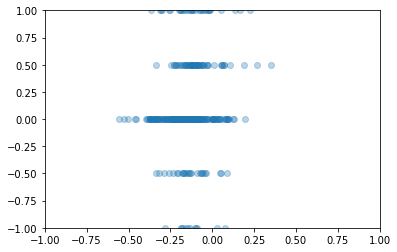

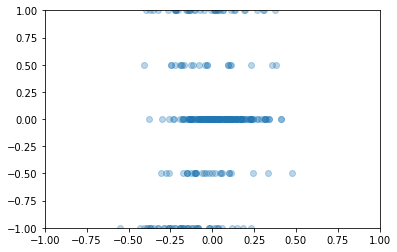

In [20]:
net.load_state_dict(torch.load('bayesian_regression_model'))
net.train(False)
points = []
sigmas = []
targets = []
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    loc, sigma = net.predict(inputs, num_samples=200)

    points.append(loc.detach().cpu().numpy())
    sigmas.append(sigma.detach().cpu().numpy())
    targets.append(target.detach().cpu().numpy())

sigmas = np.concatenate(sigmas)
points = np.concatenate(points)
targets = np.concatenate(targets)
print(f'RMSE: {rmse(points, targets)}')
print(f'mae: {mae(points, targets)}')
print(f'mae (economic): {mae(points[:, 0], targets[:, 0])}')
print(f'mae (worldview): {mae(points[:, 1], targets[:, 1])}')
print(f'Spearman correlation (econoimic): {spearmanr(points[:, 0], targets[:, 0])}')
print(f'Spearman correlation (worldview): {spearmanr(points[:, 1], targets[:, 1])}')

plt.scatter(points[:, 0], targets[:, 0], alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1);
plt.show()

plt.scatter(points[:, 1], targets[:, 1], alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1);
plt.show()

# plt.hist(sigmas[:,0])
# plt.show()

# plt.hist(sigmas[:, 1])
# plt.show()

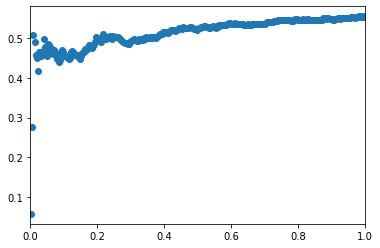

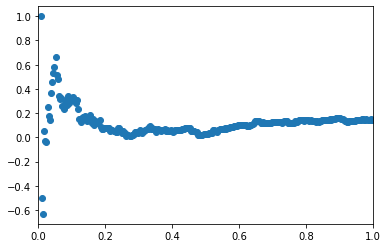

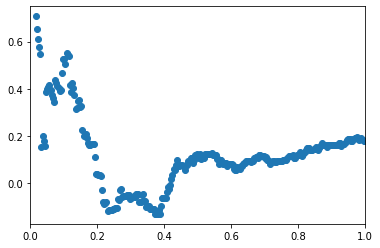

In [10]:
sig_prod = np.sqrt(sigmas[:, 0]*sigmas[:, 1])
x = []
y = []

sorted_sigmas = np.sort(sig_prod)

for percent in range(sorted_sigmas.shape[0]):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/sig_prod.shape[0]
    y_ = rmse(points[selected], targets[selected])
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);
plt.show()

x = []
y = []
for percent in range(sorted_sigmas.shape[0]):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/sig_prod.shape[0]
    y_ = spearmanr(points[selected][:,0], targets[selected][:,0]).correlation
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);
plt.show()

x = []
y = []
for percent in range(sorted_sigmas.shape[0]):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/sig_prod.shape[0]
    y_ = spearmanr(points[selected][:,1], targets[selected][:,1]).correlation
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);
plt.show()

RMSE: 0.5778538584709167
mae: 0.37985682487487793
mae (economic): 0.3874475359916687
mae (worldview): 0.37226608395576477
Spearman correlation (economic): SpearmanrResult(correlation=0.09992390372684294, pvalue=0.08720631490434365)
Spearman correlation (worldview): SpearmanrResult(correlation=0.33295621628850536, pvalue=4.841797064287847e-09)


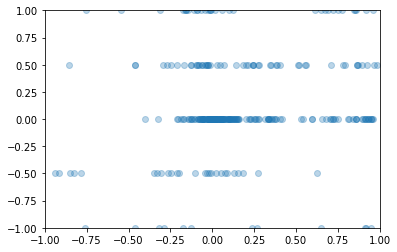

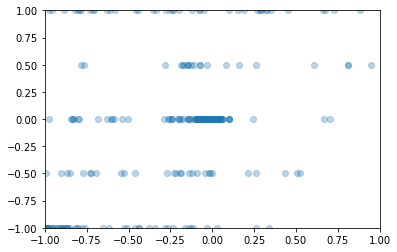

In [19]:
net.load_state_dict(torch.load('bayesian_regression_model2'))
net.train(False)
points2 = []
sigmas2 = []
targets2 = []
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    loc, sigma = net.predict(inputs, num_samples=200)
    points2.append(loc.detach().cpu().numpy())
    sigmas2.append(sigma.detach().cpu().numpy())
    targets2.append(target.detach().cpu().numpy())

sigmas2 = np.concatenate(sigmas2)
points2 = np.concatenate(points2)
targets2 = np.concatenate(targets2)
print(f'RMSE: {rmse(points2, targets2)}')
print(f'mae: {mae(points2, targets)}')
print(f'mae (economic): {mae(points2[:, 0], targets2[:, 0])}')
print(f'mae (worldview): {mae(points2[:, 1], targets2[:, 1])}')
print(f'Spearman correlation (economic): {spearmanr(points2[:, 0], targets2[:, 0])}')
print(f'Spearman correlation (worldview): {spearmanr(points2[:, 1], targets2[:, 1])}')

plt.scatter(points2[:, 0], targets2[:, 0], alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1);
plt.show()

plt.scatter(points2[:, 1], targets2[:, 1], alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1);
plt.show()

# plt.hist(sigmas2[:,0])
# plt.show()

# plt.hist(sigmas2[:, 1])
# plt.show()

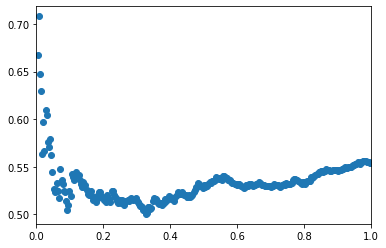

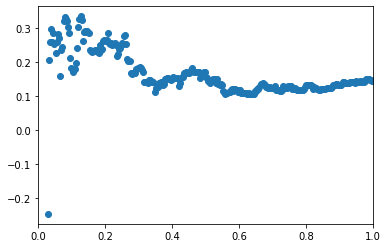

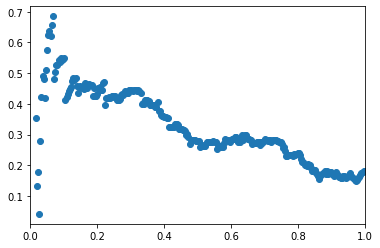

In [12]:
sig_prod = np.sqrt(sigmas2[:, 0]*sigmas2[:, 1])
x = []
y = []

sorted_sigmas = np.sort(sig_prod)

for percent in range(sorted_sigmas.shape[0]):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/sig_prod.shape[0]
    y_ = rmse(points[selected], targets[selected])
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);
plt.show()

x = []
y = []
for percent in range(sorted_sigmas.shape[0]):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/sig_prod.shape[0]
    y_ = spearmanr(points[selected][:,0], targets[selected][:,0]).correlation
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);
plt.show()

x = []
y = []
for percent in range(sorted_sigmas.shape[0]):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/sig_prod.shape[0]
    y_ = spearmanr(points[selected][:,1], targets[selected][:,1]).correlation
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);
plt.show()

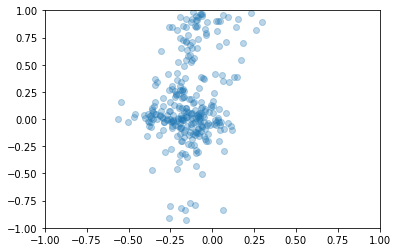

In [13]:
# oś ekonomiczna -1 lewica 1 prawica
plt.scatter(points[:, 0], points2[:, 0], alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1);

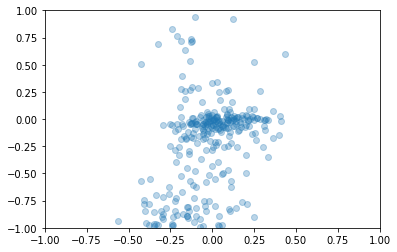

In [14]:
#oś światopoglądowa -1 liberalizm, 1 konserwatyzm
plt.scatter(points[:, 1], points2[:, 1], alpha=0.3)
plt.xlim(-1, 1)
plt.ylim(-1, 1);